# **GCN**

### **Libraries**

In [1]:
!pip install torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.7/63.7 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 18.8 MB/s eta 0:00:00


In [2]:
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from torch_geometric.data import Data, DataLoader
from scipy.spatial.distance import cdist
from torch_geometric.nn import GCNConv
import matplotlib.pyplot as plt
import torch.nn.functional as F
from tqdm import tqdm
import torch.nn as nn
import numpy as np
import torch
import cv2
import os

### **GCN Model**

In [ ]:
class GCN(nn.Module):
    def __init__(self, in_channels, hidden_channels, num_classes, dropout=0.5):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, hidden_channels // 2)
        self.fc = nn.Linear(hidden_channels // 2, num_classes)
        self.dropout = dropout
        
    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        
        # gcn layers
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        
        x = self.conv3(x, edge_index)
        x = F.relu(x)
        
        # global mean pooling
        from torch_geometric.nn import global_mean_pool
        x = global_mean_pool(x, batch)
        
        # classification head
        x = self.fc(x)
        return F.log_softmax(x, dim=1)

### **Image to Graph Conversion**

In [ ]:
def image_to_graph(img_path, img_size=128, num_superpixels=100, k_neighbors=8):
    # image preprocessing 
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (img_size, img_size))
    
    # normalization
    img = img.astype(np.float32) / 255.0
    
    # create superpixels with simple grid-based approach
    h, w = img.shape
    grid_h = int(np.sqrt(num_superpixels))
    grid_w = int(np.sqrt(num_superpixels))
    
    node_features = []
    node_positions = []
    
    step_h = h // grid_h
    step_w = w // grid_w
    
    for i in range(grid_h):
        for j in range(grid_w):
            # extract superpixel region
            y1, y2 = i * step_h, min((i + 1) * step_h, h)
            x1, x2 = j * step_w, min((j + 1) * step_w, w)
            region = img[y1:y2, x1:x2]
            
            # extract features: mean, std, max, min
            features = [
                np.mean(region),
                np.std(region),
                np.max(region),
                np.min(region)
            ]
            node_features.append(features)
            
            # store center position
            center_y = (y1 + y2) / 2
            center_x = (x1 + x2) / 2
            node_positions.append([center_y, center_x])
    
    node_features = np.array(node_features, dtype=np.float32)
    node_positions = np.array(node_positions, dtype=np.float32)
    
    # create edges with KNN
    distances = cdist(node_positions, node_positions, metric='euclidean')
    edges = []
    
    for i in range(len(node_positions)):
        # get k nearest neighbors (excluding self)
        nearest = np.argsort(distances[i])[1:k_neighbors+1]
        for j in nearest:
            edges.append([i, j])
    
    edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()
    x = torch.tensor(node_features, dtype=torch.float)
    
    return Data(x=x, edge_index=edge_index)

### **Dataset Preparation**

In [ ]:
def prepare_dataset(data_dir, img_size=128, num_superpixels=100):
    graphs = []
    labels = []
    label_map = {'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}
    
    for class_name, label in label_map.items():
        class_dir = os.path.join(data_dir, class_name)
        if not os.path.exists(class_dir):
            print(f"Warning: {class_dir} not found, skipping...")
            continue
            
        img_files = [f for f in os.listdir(class_dir) if f.endswith(('.jpg', '.png', '.jpeg'))]
        
        print(f"Processing {class_name} ({len(img_files)} images)...")
        for img_file in tqdm(img_files):
            img_path = os.path.join(class_dir, img_file)
            try:
                graph = image_to_graph(img_path, img_size, num_superpixels)
                graph.y = torch.tensor([label], dtype=torch.long)
                graphs.append(graph)
                labels.append(label)
            except Exception as e:
                print(f"Error processing {img_path}: {e}")
    
    return graphs, labels

### **Training Function**

In [6]:
def train(model, loader, optimizer, device):
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    
    for data in loader:
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data)
        loss = F.nll_loss(out, data.y)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        pred = out.argmax(dim=1)
        correct += (pred == data.y).sum().item()
        total += data.y.size(0)
    
    return total_loss / len(loader), correct / total

### **Evaluation Function**

In [7]:
def evaluate(model, loader, device):
    model.eval()
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for data in loader:
            data = data.to(device)
            out = model(data)
            pred = out.argmax(dim=1)
            
            correct += (pred == data.y).sum().item()
            total += data.y.size(0)
            
            all_preds.extend(pred.cpu().numpy())
            all_labels.extend(data.y.cpu().numpy())
    
    return correct / total, all_preds, all_labels

### **Configuration**

In [8]:
DATA_DIR = '/kaggle/input/brain-tumor-mri-dataset/Training'
DATA_TEST_DIR = '/kaggle/input/brain-tumor-mri-dataset/Testing'
BATCH_SIZE = 32
HIDDEN_CHANNELS = 128
NUM_CLASSES = 4
LEARNING_RATE = 0.001
EPOCHS = 300
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [9]:
print(f"Using device: {DEVICE}")

Using device: cpu


In [10]:
graphs, labels = prepare_dataset(DATA_DIR)

Processing glioma (1321 images)...


100%|██████████| 1321/1321 [00:30<00:00, 43.22it/s]


Processing meningioma (1339 images)...


100%|██████████| 1339/1339 [00:29<00:00, 46.05it/s]


Processing notumor (1595 images)...


100%|██████████| 1595/1595 [00:26<00:00, 61.09it/s]


Processing pituitary (1457 images)...


100%|██████████| 1457/1457 [00:26<00:00, 55.81it/s]


In [11]:
print(f"Total graphs: {len(graphs)}")

Total graphs: 5712


In [12]:
print(f"Class distribution: {np.bincount(labels)}")

Class distribution: [1321 1339 1595 1457]


In [13]:
train_graphs, val_graphs, train_labels, val_labels = train_test_split(
    graphs, labels, test_size=0.15, random_state=42, stratify=labels
)

In [14]:
test_graphs, test_labels = prepare_dataset(DATA_TEST_DIR)

Processing glioma (300 images)...


100%|██████████| 300/300 [00:05<00:00, 56.02it/s]


Processing meningioma (306 images)...


100%|██████████| 306/306 [00:05<00:00, 58.90it/s]


Processing notumor (405 images)...


100%|██████████| 405/405 [00:07<00:00, 54.07it/s]


Processing pituitary (300 images)...


100%|██████████| 300/300 [00:05<00:00, 57.22it/s]


### **Create data loaders**

In [15]:
train_loader = DataLoader(train_graphs, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_graphs, batch_size=BATCH_SIZE)
test_loader = DataLoader(test_graphs, batch_size=BATCH_SIZE)

/tmp/ipykernel_17/4289797770.py:1: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  train_loader = DataLoader(train_graphs, batch_size=BATCH_SIZE, shuffle=True)
/tmp/ipykernel_17/4289797770.py:2: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  val_loader = DataLoader(val_graphs, batch_size=BATCH_SIZE)
/tmp/ipykernel_17/4289797770.py:3: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  test_loader = DataLoader(test_graphs, batch_size=BATCH_SIZE)


### **Initialize model**

In [16]:
in_channels = graphs[0].x.shape[1]
model = GCN(in_channels, HIDDEN_CHANNELS, NUM_CLASSES).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [ ]:
print(f"Model parameters: {sum(p.numel() for p in model.parameters())}")


Model parameters: 25668


### **Training loop**

In [ ]:
best_val_acc = 0
train_losses = []
val_accs = []
    
for epoch in range(1, EPOCHS + 1):
    train_loss, train_acc = train(model, train_loader, optimizer, DEVICE)
    val_acc, _, _ = evaluate(model, val_loader, DEVICE)
        
    train_losses.append(train_loss)
    val_accs.append(val_acc)
        
    print(f'Epoch: {epoch:03d}, Train Loss: {train_loss:.4f}, 'f'Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}')
        
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), 'best_gcn_model.pt')

Epoch: 001, Train Loss: 1.2386, Train Acc: 0.3973, Val Acc: 0.5951
Epoch: 002, Train Loss: 1.0438, Train Acc: 0.5843, Val Acc: 0.5998
Epoch: 003, Train Loss: 0.9702, Train Acc: 0.6150, Val Acc: 0.6441
Epoch: 004, Train Loss: 0.9279, Train Acc: 0.6208, Val Acc: 0.6441
Epoch: 005, Train Loss: 0.9124, Train Acc: 0.6266, Val Acc: 0.6173
Epoch: 006, Train Loss: 0.8950, Train Acc: 0.6321, Val Acc: 0.6488
Epoch: 007, Train Loss: 0.8784, Train Acc: 0.6515, Val Acc: 0.6558
Epoch: 008, Train Loss: 0.8716, Train Acc: 0.6517, Val Acc: 0.6219
Epoch: 009, Train Loss: 0.8581, Train Acc: 0.6529, Val Acc: 0.6966
Epoch: 010, Train Loss: 0.8478, Train Acc: 0.6585, Val Acc: 0.7048
Epoch: 011, Train Loss: 0.8347, Train Acc: 0.6680, Val Acc: 0.6943
Epoch: 012, Train Loss: 0.8206, Train Acc: 0.6711, Val Acc: 0.6709
Epoch: 013, Train Loss: 0.8108, Train Acc: 0.6779, Val Acc: 0.7048
Epoch: 014, Train Loss: 0.8081, Train Acc: 0.6803, Val Acc: 0.7141
Epoch: 015, Train Loss: 0.7941, Train Acc: 0.6877, Val Acc: 0.

### **Load best model and evaluate on test set**

In [19]:
model.load_state_dict(torch.load('best_gcn_model.pt'))
test_acc, test_preds, test_labels = evaluate(model, test_loader, DEVICE)

In [ ]:
print(f"Test Accuracy: {test_acc:.4f}")


Test Accuracy: 0.8299


### **Classification report**

In [ ]:
class_names = ['Glioma', 'Meningioma', 'No Tumor', 'Pituitary']
print("Classification Report:")
print(classification_report(test_labels, test_preds, target_names=class_names))


Classification Report:
              precision    recall  f1-score   support

      Glioma       0.95      0.69      0.80       300
  Meningioma       0.66      0.69      0.67       306
    No Tumor       0.84      0.97      0.90       405
   Pituitary       0.92      0.92      0.92       300

    accuracy                           0.83      1311
   macro avg       0.84      0.82      0.82      1311
weighted avg       0.84      0.83      0.83      1311



### **Confusion matrix**

In [ ]:
cm = confusion_matrix(test_labels, test_preds)
print("Confusion Matrix:")
print(cm)


Confusion Matrix:
[[207  85   3   5]
 [  7 211  71  17]
 [  3   6 394   2]
 [  1  20   3 276]]


### **Plot training curves**


Training curves saved to 'gcn_training_curves.png'


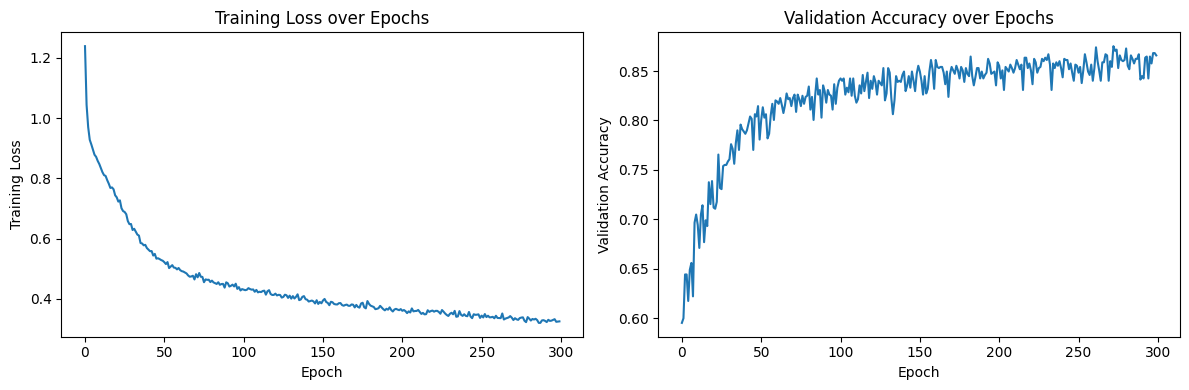

In [23]:
plt.figure(figsize=(12, 4))
    
plt.subplot(1, 2, 1)
plt.plot(train_losses)
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.title('Training Loss over Epochs')

plt.subplot(1, 2, 2)
plt.plot(val_accs)
plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy')
plt.title('Validation Accuracy over Epochs')

plt.tight_layout()
plt.savefig('gcn_training_curves.png')
print("\nTraining curves saved to 'gcn_training_curves.png'")